### Pairs Trading - Cointegration

**Motivation:**
- Security A - (Something Correlated to it) is more mean-reverting. Similar securties should trade similarily. Hence, any discrepancies between the correlated pairs should converge
- When there is a discrepancy, we form a long-short spread trade and bet on the discrepancy converging
- Pairs trading is one of the most popular statistical arbitrage strategies in traditional markets. We want to test the performance of this strategy in the cryptocurrency market, as it is still relatively new and should be fertile grounds for finding market inefficiencies
- We will use cointegration to find similar pairs as it is a robust statistical approach for identifying long-term equilibrium relationships between assets

In [1]:
from datetime import datetime
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from joblib import Parallel, delayed
from itertools import combinations

### Data 
We selected the top 1,000 currencies sorted by volume from CoinGecko. Then, we filtered out coins with fewer than 90% of daily price data points between 2018 and 2024.

In [2]:
from_pickle = pd.read_pickle('../Data/CoinGecko_px_vol_1D.pkl')

In [3]:
price_columns = [col for col in from_pickle.columns if 'price' in col]
crypto_px = from_pickle[price_columns]
crypto_px.columns = crypto_px.columns.droplevel(1)

In [4]:
crypto_px = crypto_px.loc['2018-01-01':]
crypto_px = crypto_px.drop(columns=['TUSD', 'DAI', 'WBTC', 'WETH', 'USDC', 'BSV'])

In [5]:
# Calculate the total number of data points
total_data_points = len(crypto_px)

# Calculate the number of non-NA/null entries for each coin
non_null_counts = crypto_px.notnull().sum()

# Calculate the threshold for 90% of the data points
threshold = 0.90 * total_data_points

# Filter out columns with fewer than 90% of data points
crypto_px = crypto_px.loc[:, non_null_counts >= threshold]

crypto_px

,BTC,XRP,BNB,DOGE,ADA,TRX,LTC,LINK,BCH,EOS,...,UTK,PIVX,SYS,REQ,FUN,VIB,NULS,IDEX,MDT,BORG
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,14093.606831,2.310120,8.828099,0.009091,0.747140,0.051654,230.462120,0.751033,2426.970077,7.672278,...,0.467207,10.689500,0.783623,0.867352,0.086325,0.455327,2.267259,NaN,NaN,NaN
2018-01-02,15321.932852,2.455290,9.090393,0.009335,0.807430,0.080893,255.048185,0.689388,2627.026940,9.504036,...,0.647065,11.555000,0.817777,0.809224,0.088933,0.464458,2.510494,NaN,NaN,NaN
2018-01-03,15583.885538,3.125710,9.886323,0.009592,1.075401,0.098107,248.042194,0.704623,2630.511811,10.090184,...,0.896774,10.923600,0.798803,0.795348,0.106564,0.584170,3.696732,NaN,NaN,NaN
2018-01-04,15976.365194,3.220050,9.675758,0.010098,1.179347,0.218139,244.834372,1.036826,2458.894372,11.713284,...,0.874131,10.581200,0.784280,0.826834,0.178514,0.698240,4.788923,NaN,NaN,NaN
2018-01-05,18336.922980,2.931380,16.488523,0.013841,1.077821,0.231673,254.138525,0.996575,2551.321685,9.673192,...,0.762206,9.951170,0.748309,0.761799,0.161191,0.585847,5.659994,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,58804.234500,0.552884,503.472306,0.100570,0.328140,0.127716,59.691360,10.012537,330.440521,0.467477,...,0.038229,0.193892,0.073564,0.090949,0.003115,0.057157,0.245821,0.032078,0.036722,0.170774
2024-08-13,59350.074333,0.568612,518.752217,0.107647,0.338874,0.126661,61.414267,10.561648,354.155288,0.500104,...,0.039951,0.204125,0.078151,0.094758,0.003233,0.058272,0.255234,0.033471,0.038736,0.168182
2024-08-14,60601.223178,0.576440,523.553455,0.106469,0.340317,0.128873,63.411783,10.577495,352.234629,0.507208,...,0.039211,0.203198,0.076065,0.094747,0.003273,0.058356,0.251570,0.033162,0.038288,0.171173


We have 86 coins and will select pairs from among them.

In [6]:
coins_ret = crypto_px / crypto_px.shift() - 1

In [7]:
def compute_turnover(port):
    to = (port.fillna(0)-port.shift().fillna(0)).abs().sum(1)   
    return to

In [8]:
def compute_sharpe_ratio(rets):
    mean_rets = rets.mean()*252
    vol = rets.std()*np.sqrt(252)
    sharpe_ratio = mean_rets / vol
    return sharpe_ratio

In [9]:
def compute_stats(rets):
    stats={}
    stats['avg'] = rets.mean()*252
    stats['vol'] = rets.std()*np.sqrt(252)
    stats['sharpe'] = stats['avg']/stats['vol']
    stats['hit_rate'] = rets[rets>0].count() / rets.count()
    stats = pd.DataFrame(stats)
    return stats

In [10]:
# def drawdown(px):
#     return (px / (px.expanding(min_periods=1).max()) - 1)
def drawdown(returns):
    """
    Calculate the drawdown series from the return series.
    
    Parameters:
    - returns: Series of returns (e.g., daily returns) for the strategy.
    
    Returns:
    - drawdown: Series of drawdowns over time.
    """
    # Calculate cumulative returns
    cumulative = (1 + returns).cumprod()

    # Calculate the running maximum
    running_max = cumulative.cummax()

    # Calculate drawdown
    drawdown = (cumulative - running_max) / running_max

    return drawdown

In [11]:
def duration(px):
    peak = px.expanding(min_periods=1).max()
    res = pd.DataFrame(index=px.index,columns=px.columns)
    for col in px.columns:
        for dt in px.index:
            if px.loc[dt,col] >= peak.loc[dt,col]:
                 res.loc[dt,col] = 0
            else: 
                res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1
    return res

In [12]:
def final_results(avg_return, volatility, sharpe, hit_rate, max_drawdown, max_duration, holding_period, IR):
    stats = {}
    stats['Return (Ann.)'] = f"{(avg_return * 100):.2f}%"  
    stats['Volatility (Ann.)'] = f"{(volatility * 100):.2f}%"  
    stats['Sharpe Ratio'] = f"{sharpe:.2f}"  
    stats['Hit Rate'] = f"{(hit_rate * 100):.2f}%"  
    stats['Max Drawdown'] = f"{(max_drawdown):.2f}%"  
    stats['Max Duration'] = f"{max_duration:.2f} days"  
    stats['Holding Period'] = f"{holding_period:.2f} days"  
    stats['Information Ratio'] = f"{IR:.2f}" 

    stats_df = pd.DataFrame(stats, index=['Cointegration']).T  
    return stats_df

### Pairs Selection

Pairs are selected and updated every half year, making the process more practical for real-time implementation. Here’s how it works:

- **Rolling OLS Regression**: Every six months, perform Ordinary Least Squares (OLS) regression on the log prices of two securities over the past year to obtain the residuals:
  
  $$
  \log(p_{i,t}) = \alpha + \beta \log(p_{j,t}) + \epsilon_t
  $$
  
- **Stationarity Test**: Apply the Augmented Dickey-Fuller (ADF) test to the residuals to check for stationarity. A p-value < 0.05 indicates that the residuals are stationary.

- **Selection Criteria**: For each coin, select the pair with the most negative test statistic from the ADF test, ensuring all selected pairs have p-values less than 0.05.

In [13]:
def adf_for_pair(symbol_i, symbol_j, crypto_px):
    """
    Perform the ADF test on the residuals of the OLS regression between two assets.

    Parameters:
    symbol_i (str): The first asset's symbol.
    symbol_j (str): The second asset's symbol.
    in_sample_px (DataFrame): The DataFrame containing in-sample price data for the assets.

    Returns:
    tuple: A tuple containing the pair (symbol_i, symbol_j) and a tuple of (p_value, test_statistic).
    """
    # Convert raw price to log price
    crypto_log_px = np.log(crypto_px)
    
    # Handle missing data
    X = crypto_log_px[symbol_i].fillna(0).values
    Y = crypto_log_px[symbol_j].fillna(0).values

    # OLS regression
    model = sm.OLS(Y, sm.add_constant(X)).fit()
    alpha = model.params[0]
    beta = model.params[1]
    residuals = Y - beta * X - alpha

    # ADF test on residuals
    adf_result = adfuller(residuals)
    p_value = adf_result[1]
    test_statistic = adf_result[0]
    
    return (symbol_i, symbol_j), (p_value, test_statistic)

In [14]:
def select_pairs(crypto_px, significance_level=0.05, top_n=1, n_jobs=-1):
    """
    Compute ADF test results for all pairs, select the top `n` cointegrated pairs for each coin,
    and display the results along with the update date.
    
    Parameters:
    crypto_px (DataFrame): DataFrame containing price data of assets.
    significance_level (float): The significance level threshold for p-values to select cointegrated pairs.
    top_n (int): The number of top pairs to select for each coin.
    n_jobs (int): Number of parallel jobs to run.

    Returns:
    list: A sorted list of unique cointegrated pairs.
    """
    
    # Get all combinations of pairs
    symbols = crypto_px.columns.tolist()
    pairs = list(combinations(symbols, 2))

    # Parallel computation of ADF tests for all pairs
    adf_results = Parallel(n_jobs=n_jobs)(
        delayed(adf_for_pair)(symbol_i, symbol_j, crypto_px) for symbol_i, symbol_j in pairs
    )

    # Create a DataFrame with ADF results
    pairs, results = zip(*adf_results)
    adf_df = pd.DataFrame(results, columns=['p_value', 'test_statistic'], index=pairs)
    
    # Filter pairs with p-values less than the significance level
    filtered_df = adf_df[adf_df['p_value'] < significance_level]
    
    # Initialize a set to store unique pairs
    final_pairs_set = set()

    # Initialize a dictionary to store top pairs for each coin
    top_pairs_per_coin = {}

    # Iterate over all unique coins in the filtered pairs
    all_coins = set(sum([list(pair) for pair in filtered_df.index], []))
    for coin in all_coins:
        # Filter pairs where the coin is involved
        coin_pairs = filtered_df.loc[[(coin in pair) for pair in filtered_df.index]]
        
        # Sort the pairs by the ADF test statistic (smaller test statistic is better)
        sorted_pairs = coin_pairs.sort_values(by='test_statistic')
        
        # Select the top `n` pairs for this coin
        top_pairs = sorted_pairs.head(top_n)
        
        # Store the result in the dictionary
        top_pairs_per_coin[coin] = top_pairs
        
        # Add the selected pairs to the final set
        final_pairs_set.update(top_pairs.index.tolist())

    # Convert the set to a sorted list
    final_pairs = sorted(final_pairs_set)
    
    # Determine the update date as the end date of crypto_px + 1 day
    update_date = crypto_px.index[-1] + pd.Timedelta(days=1)
    print(f"Pairs Updated date: {update_date.strftime('%Y-%m-%d')}")
    
    # Display the top cointegrated pairs for each coin
    sorted_coins = sorted(top_pairs_per_coin.keys())
    for coin in sorted_coins:
        df = top_pairs_per_coin[coin]
        top_coins = [pair[1] if pair[0] == coin else pair[0] for pair in df.index]
    
    # Print the final pairs and the count
    print(f"Final pairs to be traded: {final_pairs}")
    print(f"Number of pairs to be traded: {len(final_pairs)}")
    
    return final_pairs

### Trading Strategy

#### 1. Signal Generation

- **Residual Calculation:**

  $$
  \epsilon_t = \log(p_{i,t}) - (\beta_t \log(p_{j,t}) + \alpha_t)
  $$

  where:
  - $\log(p_{i,t})$ and $\log(p_{j,t})$ are the log prices of coins $i$ and $j$ at time $t$.
  - **$\beta_t$** is calculated as:

   $$
   \beta_t = \text{Corr}_{t} \times \frac{\text{Vol}_{j,t}}{\text{Vol}_{i,t}}
   $$


    with:
    - **$\text{Corr}_{t}$** is the 90-day rolling correlation between $\log(p_{i,t})$ and $\log(p_{j,t})$.
    - **$\text{Vol}_{i,t}$** and **$\text{Vol}_{j,t}$** are the 90-day rolling volatilities of $\log(p_{i,t})$ and $\log(p_{j,t})$, respectively.
  - **$\alpha_t$** is calculated as:

  $$
  \alpha_t = \mu_{\log(p_{j,t})} - \beta_t \cdot \mu_{\log(p_{i,t})}
  $$
  
  where:
  - $\mu_{\log(p_{j,t},90)}$ is the 90-day rolling mean of $\log(p_{j,t})$.
  - $\mu_{\log(p_{i,t},90)}$ is the 90-day rolling mean of $\log(p_{i,t})$.

  
- **Z-Score Calculation:**

  $$
  z_t = \frac{\epsilon_t - \mu_t}{\sigma_t}
  $$

  where:
  - $\mu_t$ is the 90-day rolling mean of the spread.
  - $\sigma_t$ is the 90-day rolling standard deviation of the spread.

#### 2. Portfolio Construction

- **Entry Signals:**
  - **Short** coin $i$ and **long** $\beta_t$ units of coin $j$ if $z_t > 1$.
  - **Long** coin $i$ and **short** $\beta_t$ units of coin $j$ if $z_t < -1$.

- **Exit Signals:**
  - Close the position when $z_t$ moves to any of the following thresholds:

    $$
    z_t \geq -\text{threshold} \quad \text{or} \quad z_t \leq \text{threshold}
    $$

    where threshold is one of the values: 0.1, 0.2, 0.5, or 0.7.

In [15]:
def gen_signals(px, pairs, window=90):
    signal_df = {}
    for pair in pairs:
        asset_i, asset_j = pair
        
        # Forward-fill missing values and replace zeros with NaNs
        px_i = px[asset_i].replace(0, np.nan).ffill()
        px_j = px[asset_j].replace(0, np.nan).ffill()
        
        # Apply log transformation
        log_px_i = np.log(px_i)
        log_px_j = np.log(px_j)
        
        # Calculate rolling covariance and variance 
        rolling_cov = log_px_i.rolling(window=window, min_periods=1).cov(log_px_j)
        rolling_var = log_px_i.rolling(window=window, min_periods=1).var()
        
        # Calculate beta and alpha
        beta = rolling_cov / rolling_var
        alpha = log_px_j.rolling(window=window).mean() - beta * log_px_i.rolling(window=window).mean()
        
        # Calculate spread for time t using beta and alpha
        spread = log_px_i - (beta * log_px_j + alpha)
        
        # Calculate rolling mean and standard deviation of the spread using data up to t
        spread_mean = spread.rolling(window=window, min_periods=1).mean()
        spread_std = spread.rolling(window=window, min_periods=1).std()
        
        # Calculate the z-score for time t using spread(t), mean(t), and std(t)
        z_score = (spread - spread_mean) / spread_std
        
        # Store beta, alpha, spread, and z-score in a multi-level column DataFrame
        signal_df[(pair, 'beta')] = beta
        signal_df[(pair, 'alpha')] = alpha
        signal_df[(pair, 'spread')] = spread
        signal_df[(pair, 'z_score')] = z_score
    
    # Convert the dictionary to a DataFrame
    signal_df = pd.DataFrame(signal_df)
    
    return signal_df

In [16]:
def gen_port(signal_df, pairs, crypto_px, threshold=0.5):
    # Initialize a DataFrame with the same index and columns as crypto_px, filled with NaN
    pos = pd.DataFrame(index=signal_df.index, columns=crypto_px.columns)
    for pair in pairs:
        asset_i, asset_j = pair
        # Access z-scores and betas for this pair
        z_scores = signal_df[(pair, 'z_score')]
        betas = signal_df[(pair, 'beta')]

        # Set positions based on z-scores
        pos.loc[z_scores > 1, asset_i] = -1  # Short one unit of asset_i
        pos.loc[z_scores < -1, asset_i] = 1  # Long one unit of asset_i
        pos.loc[(z_scores.abs() <= threshold), asset_i] = 0  # Exit signal

        pos.loc[z_scores > 1, asset_j] = betas  # Long beta units of asset_j
        pos.loc[z_scores < -1, asset_j] = -betas  # Short beta units of asset_j
        pos.loc[(z_scores.abs() <= threshold), asset_j] = 0  # Exit signal

    # Forward-fill missing values
    pos = pos.ffill()
    # Normalize to ensure a fully-invested portfolio
    pos = pos.divide(pos.abs().sum(axis=1), axis=0).fillna(0)
    return pos

### Performance Evaluation

We evaluate the strategy's performance across four exit thresholds: 0.1, 0.2, 0.5, and 0.7. For each threshold, the following key metrics are calculated:

- **Sharpe Ratio**: Risk-adjusted return of the strategy.
- **Transaction Costs**: Average costs incurred due to trading.
- **Holding Period**: Average number of days a position is held.
- **Turnover**: Average daily proportion of the portfolio that is traded.
- **Annualized Return**: Average yearly return of the strategy.
- **Annualized Volatility**: Standard deviation of returns on an annual basis, indicating risk.

Cryptocurrencies can have commissions of ~7bps. While total slippage is unknown and will depend on the trader’s volume as well, let’s assume another 13 bps. So total all-in execution costs will be 20 bps for market-orders.

In [17]:
# Define the thresholds and initialize the arrays for storing metrics
end_of_insample = pd.Timestamp('2018-12-31')
last_available_date = crypto_px.index[-1]
thresholds = [0.1, 0.2, 0.5, 0.7]
metrics = {
    'Sharpe Ratio': np.zeros(len(thresholds)),
    'Return': np.zeros(len(thresholds)),
    'Volatility': np.zeros(len(thresholds)),
    'Holding Period': np.zeros(len(thresholds)),
    'Turnover': np.zeros(len(thresholds)),
    'Transaction Costs': np.zeros(len(thresholds)),
}

# Dictionary to store strat_net_ret for each threshold
strat_net_ret_dict = {}

# Set the start of the out-of-sample period
start_of_out_sample = end_of_insample + pd.DateOffset(days=1)

# Define half-year periods for updating pairs
update_dates = pd.date_range(start=start_of_out_sample, end=crypto_px.index[-1], freq='6MS')

# Initialize an empty DataFrame to store the complete portfolio over all periods
full_portfolio = pd.DataFrame(index=crypto_px.loc[start_of_out_sample:].index, columns=crypto_px.columns)

# Loop over each threshold to calculate metrics
for i, threshold in enumerate(thresholds):
    print(f"Evaluating with exit threshold: {threshold}")
    for start_date in update_dates:
        # Define the end of the update period (6 months later)
        end_date = start_date + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        
        # Adjust end_date if it exceeds the last available date
        if end_date > last_available_date:
            end_date = last_available_date
            
        # Select the in-sample period for pair selection
        insample_start = start_date - pd.DateOffset(years=1)
        insample_end = start_date - pd.DateOffset(days=1)
        
        # Re-select pairs based on the ADF test or any other criteria
        updated_pairs = select_pairs(crypto_px.loc[insample_start:insample_end])
        
        # Generate signals for the new pairs
        signal_df = gen_signals(crypto_px, updated_pairs, window=90)
        signal_df = signal_df.loc[start_date:end_date]
        
        # Generate portfolio for the selected pairs
        port = gen_port(signal_df, updated_pairs, crypto_px, threshold)
        
        # Store the generated portfolio in the full_portfolio DataFrame
        full_portfolio.loc[start_date:end_date, :] = port
    
    # Calculate out-of-sample daily returns for the entire period
    out_sample_ret = coins_ret.loc[start_of_out_sample:][full_portfolio.columns]
    strat_gross_ret = (full_portfolio.shift() * out_sample_ret).sum(axis=1)
    
    # Calculate net returns with transaction costs
    to = compute_turnover(full_portfolio)
    tcost_bps = 20  # (commissions + slippage)
    strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)
    
    # Store the net returns for the current threshold
    strat_net_ret_dict[threshold] = strat_net_ret
    
    # Compute Sharpe ratio
    sharpe_ratio = compute_sharpe_ratio(strat_net_ret)
    metrics['Sharpe Ratio'][i] = sharpe_ratio
    
    # Compute transaction costs
    total_tcost = to * tcost_bps * 1e-4
    metrics['Transaction Costs'][i] = total_tcost.mean()
    
    # Compute holding period (average number of days a position is held)
    metrics['Holding Period'][i] = 2/to.mean()
    
    # Store turnover
    metrics['Turnover'][i] = to.mean()
    
    # Compute return 
    returns = strat_net_ret.mean()
    metrics['Return'][i] = returns
    
    # Compute volatility
    volatility = strat_net_ret.std()
    metrics['Volatility'][i] = volatility
    
# Convert metrics to a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics, index=thresholds)

Evaluating with exit threshold: 0.1
Pairs Updated date: 2019-01-01
Final pairs to be traded: [('ADA', 'MDT'), ('AMB', 'BLZ'), ('ARK', 'ANT'), ('ARK', 'SBD'), ('BAT', 'SWFTC'), ('BCH', 'DCR'), ('BCH', 'XMR'), ('BNB', 'DCR'), ('BTC', 'MKR'), ('CTXC', 'PIVX'), ('CVC', 'MDT'), ('DOGE', 'SWFTC'), ('ELF', 'CTXC'), ('ELF', 'RLC'), ('ELF', 'STORJ'), ('ENJ', 'BORG'), ('ENJ', 'MED'), ('ENJ', 'REN'), ('ENJ', 'RVN'), ('EOS', 'ZEN'), ('ETC', 'GNO'), ('ETC', 'ZEN'), ('GFT', 'BLZ'), ('GFT', 'POWR'), ('GLM', 'BLZ'), ('LINK', 'BTG'), ('LRC', 'ADX'), ('LTC', 'ZEC'), ('MANA', 'DGB'), ('MED', 'DENT'), ('MTL', 'ICX'), ('NEO', 'GNO'), ('NMR', 'MLN'), ('OMG', 'LSK'), ('ONT', 'GAS'), ('QTUM', 'GAS'), ('QTUM', 'LSK'), ('SNT', 'MDT'), ('SNX', 'SYS'), ('STEEM', 'ICX'), ('STEEM', 'NULS'), ('STMX', 'IOST'), ('STMX', 'XVG'), ('STORJ', 'LRC'), ('STORJ', 'PRO'), ('SWFTC', 'IDEX'), ('THETA', 'SWFTC'), ('THETA', 'TRAC'), ('THETA', 'ZIL'), ('TRX', 'MANA'), ('UQC', 'STRAX'), ('UTK', 'MDT'), ('VGX', 'IOTA'), ('VIB', 'MDT'

Pairs Updated date: 2022-07-01
Final pairs to be traded: [('ADA', 'STEEM'), ('ANT', 'REQ'), ('ARK', 'BLZ'), ('BAT', 'CTXC'), ('BCH', 'XEM'), ('BNB', 'GLM'), ('BTC', 'GLM'), ('CVC', 'ARDR'), ('CVC', 'OMG'), ('DASH', 'MED'), ('DASH', 'ONT'), ('DASH', 'SNT'), ('DASH', 'XEM'), ('DENT', 'UTK'), ('DGB', 'BTG'), ('DGB', 'XNO'), ('DOGE', 'EOS'), ('ELF', 'CVC'), ('ENJ', 'GFT'), ('EOS', 'XDC'), ('EOS', 'XNO'), ('ETC', 'SNX'), ('GAS', 'SBD'), ('GFT', 'NULS'), ('GLM', 'WAVES'), ('GNO', 'REQ'), ('IOST', 'MTL'), ('LINK', 'IOTA'), ('LINK', 'RVN'), ('LRC', 'REQ'), ('LSK', 'BTG'), ('LTC', 'ADX'), ('LTC', 'ARK'), ('MANA', 'MDT'), ('MED', 'VIB'), ('MKR', 'BORG'), ('MKR', 'XVG'), ('MLN', 'VIB'), ('NEO', 'DGB'), ('NMR', 'XEM'), ('POWR', 'REQ'), ('QTUM', 'UTK'), ('REN', 'ICX'), ('REQ', 'IDEX'), ('RVN', 'UTK'), ('SBD', 'STRAX'), ('SNX', 'DCR'), ('SNX', 'FUN'), ('STEEM', 'MLN'), ('STEEM', 'ZRX'), ('STMX', 'MLN'), ('STORJ', 'GFT'), ('SYS', 'MDT'), ('THETA', 'AMB'), ('THETA', 'RLC'), ('TRX', 'MTL'), ('UQC', 'ST

Pairs Updated date: 2020-01-01
Final pairs to be traded: [('ADA', 'VIC'), ('ADX', 'SYS'), ('ADX', 'XVG'), ('AMB', 'UQC'), ('ANT', 'UQC'), ('ARDR', 'MTL'), ('BAT', 'NMR'), ('BCH', 'XMR'), ('BNB', 'XMR'), ('BTC', 'UQC'), ('BTG', 'XEM'), ('DASH', 'PRO'), ('DGB', 'BLZ'), ('DGB', 'CVC'), ('DGB', 'GAS'), ('DGB', 'GLM'), ('DGB', 'ICX'), ('DGB', 'OMG'), ('DGB', 'SBD'), ('DGB', 'SNT'), ('DOGE', 'XMR'), ('ELF', 'DGB'), ('ELF', 'STORJ'), ('ENJ', 'VIC'), ('EOS', 'MTL'), ('ETC', 'MED'), ('ETC', 'XMR'), ('FUN', 'MDT'), ('GFT', 'POWR'), ('IOST', 'VIC'), ('LINK', 'MLN'), ('LRC', 'PIVX'), ('LRC', 'STMX'), ('LRC', 'WAVES'), ('LSK', 'SNT'), ('LTC', 'GNO'), ('LTC', 'XMR'), ('MANA', 'DGB'), ('MDT', 'BORG'), ('MKR', 'UQC'), ('NEO', 'UQC'), ('NMR', 'UQC'), ('OMG', 'CTXC'), ('OMG', 'NULS'), ('ONT', 'MTL'), ('QTUM', 'ARDR'), ('REN', 'MDT'), ('REQ', 'MDT'), ('RLC', 'UQC'), ('RVN', 'MTL'), ('SNT', 'IDEX'), ('SNX', 'MLN'), ('STEEM', 'ARK'), ('STEEM', 'PIVX'), ('STEEM', 'STRAX'), ('THETA', 'UQC'), ('TRAC', 'UQC'),

Pairs Updated date: 2023-07-01
Final pairs to be traded: [('ADA', 'LINK'), ('ADA', 'MKR'), ('ANT', 'FUN'), ('ARDR', 'XEM'), ('ARK', 'WAXP'), ('ARK', 'XEM'), ('BAT', 'MLN'), ('BLZ', 'ARDR'), ('BTC', 'DOGE'), ('CVC', 'ARK'), ('DOGE', 'XMR'), ('ELF', 'GAS'), ('ENJ', 'DENT'), ('ENJ', 'POWR'), ('EOS', 'ETC'), ('EOS', 'MKR'), ('EOS', 'RVN'), ('EOS', 'XMR'), ('GAS', 'NULS'), ('GAS', 'TRAC'), ('GFT', 'DENT'), ('GFT', 'PIVX'), ('GLM', 'MED'), ('IOTA', 'CVC'), ('LRC', 'MLN'), ('LRC', 'NMR'), ('LSK', 'MLN'), ('LSK', 'SYS'), ('LTC', 'XVG'), ('MANA', 'DENT'), ('MANA', 'IOST'), ('MANA', 'SNT'), ('MANA', 'ZIL'), ('MTL', 'IDEX'), ('MTL', 'SNT'), ('NEO', 'DENT'), ('OMG', 'FUN'), ('OMG', 'REQ'), ('OMG', 'XVG'), ('PRO', 'DCR'), ('QTUM', 'ADX'), ('QTUM', 'DENT'), ('QTUM', 'ICX'), ('QTUM', 'ONT'), ('REN', 'STMX'), ('REN', 'UTK'), ('RLC', 'CTXC'), ('RLC', 'SWFTC'), ('SBD', 'XNO'), ('SNX', 'DENT'), ('SNX', 'GNO'), ('STEEM', 'IOST'), ('STORJ', 'XEM'), ('STORJ', 'ZEN'), ('THETA', 'DENT'), ('THETA', 'DGB'), ('T

Pairs Updated date: 2021-01-01
Final pairs to be traded: [('ADA', 'BORG'), ('ADA', 'MED'), ('ADA', 'MKR'), ('ADX', 'BTG'), ('AMB', 'BTG'), ('ANT', 'IDEX'), ('ANT', 'SWFTC'), ('ARK', 'FUN'), ('ARK', 'SYS'), ('BAT', 'DENT'), ('BCH', 'DASH'), ('BLZ', 'BTG'), ('BNB', 'MED'), ('BTC', 'MTL'), ('CTXC', 'SWFTC'), ('CVC', 'BTG'), ('DCR', 'SWFTC'), ('DGB', 'MED'), ('ELF', 'GFT'), ('ENJ', 'GFT'), ('EOS', 'SWFTC'), ('ETC', 'BTG'), ('GAS', 'FUN'), ('GAS', 'MTL'), ('GLM', 'BTG'), ('GNO', 'MDT'), ('GNO', 'MED'), ('ICX', 'FUN'), ('IOTA', 'DENT'), ('LINK', 'DENT'), ('LINK', 'MED'), ('LINK', 'STMX'), ('LRC', 'DENT'), ('LSK', 'MTL'), ('LTC', 'STEEM'), ('MANA', 'MED'), ('MLN', 'MDT'), ('MLN', 'UTK'), ('NEO', 'MED'), ('NMR', 'SNT'), ('OMG', 'FUN'), ('ONT', 'BTG'), ('ONT', 'DENT'), ('ONT', 'VIB'), ('PIVX', 'FUN'), ('POWR', 'BTG'), ('PRO', 'BTG'), ('QTUM', 'ARDR'), ('QTUM', 'DENT'), ('QTUM', 'GFT'), ('QTUM', 'IOST'), ('REN', 'DENT'), ('RLC', 'FUN'), ('RVN', 'BTG'), ('SBD', 'SWFTC'), ('SNX', 'DENT'), ('STEEM'

Pairs Updated date: 2024-07-01
Final pairs to be traded: [('ADA', 'IOTA'), ('AMB', 'STMX'), ('ARDR', 'MTL'), ('BAT', 'MDT'), ('BCH', 'NULS'), ('BCH', 'PRO'), ('BNB', 'XDC'), ('BTC', 'REQ'), ('BTG', 'REQ'), ('DASH', 'STMX'), ('DCR', 'MDT'), ('DENT', 'ADX'), ('DGB', 'MLN'), ('DGB', 'SYS'), ('DOGE', 'REQ'), ('ELF', 'GFT'), ('ENJ', 'IOST'), ('ENJ', 'LRC'), ('EOS', 'ZIL'), ('ETC', 'RLC'), ('ETC', 'XNO'), ('GLM', 'REQ'), ('GNO', 'UQC'), ('IOST', 'OMG'), ('IOTA', 'CTXC'), ('IOTA', 'FUN'), ('LINK', 'UQC'), ('LSK', 'PIVX'), ('LTC', 'XVG'), ('MANA', 'STMX'), ('MED', 'IOST'), ('MKR', 'ANT'), ('MKR', 'GLM'), ('NEO', 'PIVX'), ('NEO', 'VIB'), ('NMR', 'RLC'), ('OMG', 'ICX'), ('ONT', 'LSK'), ('POWR', 'SNT'), ('RVN', 'SYS'), ('RVN', 'XVG'), ('SBD', 'SNT'), ('SNX', 'FUN'), ('STEEM', 'BORG'), ('STEEM', 'PIVX'), ('STEEM', 'QTUM'), ('STORJ', 'ARK'), ('STORJ', 'BLZ'), ('STORJ', 'GAS'), ('SWFTC', 'REQ'), ('THETA', 'REQ'), ('TRAC', 'UQC'), ('TRX', 'GFT'), ('UTK', 'IDEX'), ('VGX', 'XDC'), ('WAVES', 'IOST'), ('

Pairs Updated date: 2022-01-01
Final pairs to be traded: [('ADA', 'STRAX'), ('ADX', 'SNT'), ('AMB', 'XNO'), ('ANT', 'CTXC'), ('ANT', 'NULS'), ('ARK', 'XNO'), ('BAT', 'CTXC'), ('BAT', 'POWR'), ('BCH', 'XNO'), ('BLZ', 'UTK'), ('BNB', 'ENJ'), ('BTC', 'VGX'), ('BTG', 'MTL'), ('BTG', 'UQC'), ('CTXC', 'SYS'), ('CVC', 'ICX'), ('CVC', 'IOST'), ('DASH', 'XNO'), ('DENT', 'ARDR'), ('DENT', 'MTL'), ('DGB', 'XNO'), ('DOGE', 'RLC'), ('ELF', 'VGX'), ('EOS', 'XNO'), ('ETC', 'VGX'), ('GAS', 'XNO'), ('GLM', 'VIC'), ('GNO', 'FUN'), ('IOTA', 'CTXC'), ('LINK', 'VGX'), ('LRC', 'CTXC'), ('LSK', 'XNO'), ('LTC', 'MKR'), ('LTC', 'VGX'), ('LTC', 'XLM'), ('MANA', 'CTXC'), ('MED', 'MTL'), ('MTL', 'STRAX'), ('NEO', 'XNO'), ('NMR', 'SNT'), ('OMG', 'XNO'), ('ONT', 'SNT'), ('PIVX', 'BORG'), ('PIVX', 'VIB'), ('PRO', 'CTXC'), ('QTUM', 'ZEN'), ('REN', 'VIC'), ('REQ', 'IDEX'), ('RVN', 'BORG'), ('SNX', 'VGX'), ('STEEM', 'VGX'), ('STMX', 'DENT'), ('STORJ', 'ENJ'), ('STORJ', 'GFT'), ('THETA', 'SBD'), ('TRAC', 'CTXC'), ('TRX'

In [18]:
print(metrics_df)

     Sharpe Ratio    Return  Volatility  Holding Period  Turnover  \
0.1      0.945908  0.000709    0.011894       20.229346  0.098866   
0.2      0.878847  0.000683    0.012336       18.512020  0.108038   
0.5      0.904451  0.000751    0.013189       16.181857  0.123595   
0.7      0.967115  0.000859    0.014102       14.839511  0.134775   

     Transaction Costs  
0.1           0.000198  
0.2           0.000216  
0.5           0.000247  
0.7           0.000270  


The performance across different thresholds is relatively robust, with only minor variations.

<Axes: xlabel='Date'>

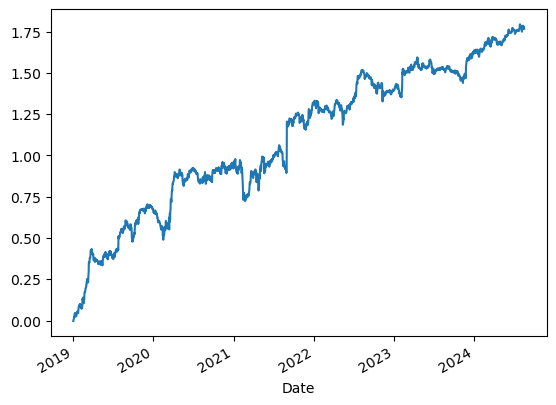

In [19]:
strat_net_ret = strat_net_ret_dict[0.7]
strat_net_ret.cumsum().plot()

We also compare the performance of our strategy against our benchmark, specifically a buy-and-hold strategy for Bitcoin. We will evaluate key metrics including alpha and beta, maximum drawdowns and maximum drawdown duration. 

In [20]:
buy_and_hold_btc = coins_ret['BTC'][start_of_out_sample:]
buy_and_hold_btc

Date
2019-01-01   -0.030762
2019-01-02    0.027551
2019-01-03    0.020533
2019-01-04   -0.024701
2019-01-05    0.010259
                ...   
2024-08-12   -0.034218
2024-08-13    0.009282
2024-08-14    0.021081
2024-08-15   -0.030726
2024-08-16   -0.018984
Name: BTC, Length: 2057, dtype: float64

In [21]:
full_sample_ret = pd.DataFrame({
    'strat_ret': strat_net_ret,
    'buy_and_hold_btc': buy_and_hold_btc
})

full_sample_stats = compute_stats(full_sample_ret)
print(full_sample_stats)

                       avg       vol    sharpe  hit_rate
strat_ret         0.216498   0.22386  0.967115  0.508994
buy_and_hold_btc  0.468641  0.541459  0.865516  0.516318


<Axes: xlabel='Date'>

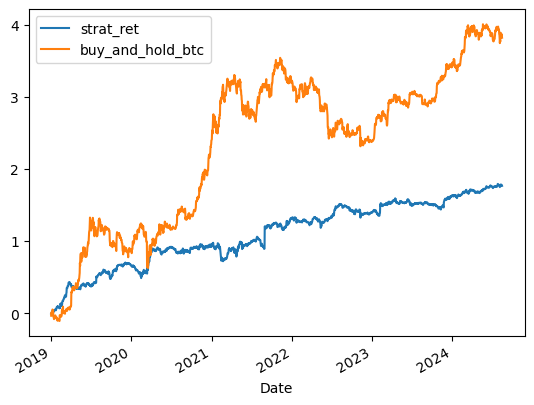

In [22]:
full_sample_ret.cumsum().plot()

In [23]:
corr = full_sample_ret.rolling(252).corr(full_sample_ret['buy_and_hold_btc'])
vol = full_sample_ret.rolling(252).std()

beta = (corr*vol).divide(vol['buy_and_hold_btc'], 0)

# Computing Point-in-Time Residual Returns
resid = full_sample_ret - beta.multiply(full_sample_ret['buy_and_hold_btc'], axis=0)
print(resid)
print(resid.corr())

# The information ratio
IR = resid.mean()/resid.std()*np.sqrt(252)
print(f"Information ratio is {IR['strat_ret']}")

           strat_ret  buy_and_hold_btc
Date                                  
2019-01-01       NaN               NaN
2019-01-02       NaN               NaN
2019-01-03       NaN               NaN
2019-01-04       NaN               NaN
2019-01-05       NaN               NaN
...              ...               ...
2024-08-12 -0.009819      3.191891e-16
2024-08-13  0.004392     -8.673617e-17
2024-08-14 -0.001412     -2.012279e-16
2024-08-15 -0.001694      2.949030e-16
2024-08-16 -0.009178      1.804112e-16

[2057 rows x 2 columns]
                  strat_ret  buy_and_hold_btc
strat_ret          1.000000         -0.025434
buy_and_hold_btc  -0.025434          1.000000
Information ratio is 0.9016655515440292


The correlation of the residual returns with Bitcoin is -0.03

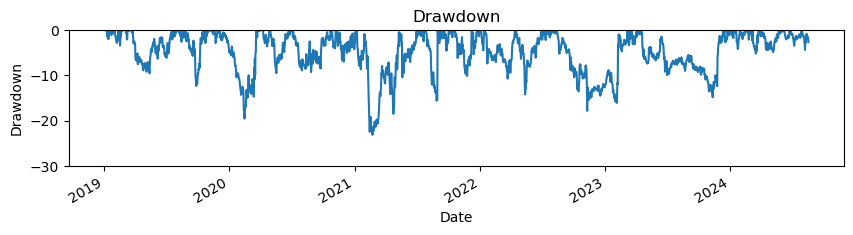

The max drawdown is -23.15433496412289


In [24]:
# Plot drawdown
# dd = drawdown(full_sample_ret['strat_ret'].cumsum())
dd = drawdown(full_sample_ret['strat_ret']) * 100
plt.figure(figsize=(10, 2))
dd.plot()
plt.ylim(-30, 0)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()
print(f"The max drawdown is {dd.min()}")

In [25]:
ddd = duration(full_sample_ret.cumsum())
ddd

,strat_ret,buy_and_hold_btc
Date,,
2019-01-01,0,0
2019-01-02,0,0
2019-01-03,0,0
2019-01-04,0,1
2019-01-05,0,2
...,...,...
2024-08-12,15,83
2024-08-13,16,84
2024-08-14,17,85


<Axes: xlabel='Date'>

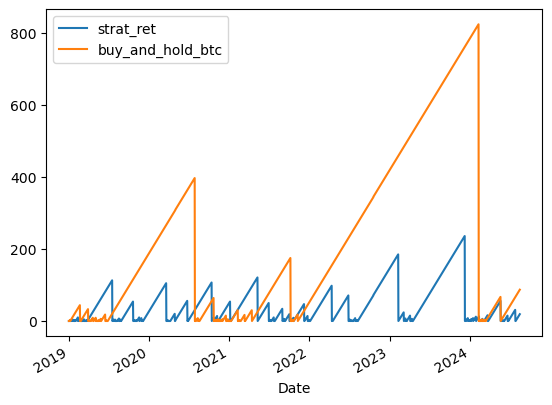

In [26]:
ddd.plot()

In [27]:
# maximum drawdown duration
ddd.max()

strat_ret           236
buy_and_hold_btc    824
dtype: object

In [28]:
avg_return = full_sample_stats.loc['strat_ret', 'avg']
volatility = full_sample_stats.loc['strat_ret', 'vol']
sharpe = full_sample_stats.loc['strat_ret', 'sharpe']
hit_rate = full_sample_stats.loc['strat_ret', 'hit_rate']
max_drawdown = dd.min()
max_duration = ddd.max().loc['strat_ret']
holding_period = metrics_df.loc[0.1, 'Holding Period']
information_ratio = IR['strat_ret']

# Calculate strategy stats with formatted percentages and days
stats = final_results(avg_return, volatility, sharpe, hit_rate, max_drawdown, max_duration, holding_period, information_ratio)
print(stats)

                  Cointegration
Return (Ann.)            21.65%
Volatility (Ann.)        22.39%
Sharpe Ratio               0.97
Hit Rate                 50.90%
Max Drawdown            -23.15%
Max Duration        236.00 days
Holding Period       20.23 days
Information Ratio          0.90


Overall, the cointegration strategy did not perform as well as expected. While cointegration is theoretically sound, its practical application can be complex and less effective. We will further explore correlation-based pairs trading in the next steps to seek more effective strategies.